Notebook objective: Test mixed effects LM model with random intercept for store_id, rank deficient columns dropped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Get rid of rank-deficiency by dropping highly correlated columns
# The below setting gets rid of the rank deficiency error & yields the best testing performance
df = df.drop(
    [
    "num_distinct_items", 
    "total_outstanding_orders", 
    "total_busy_dashers", 
    #"total_onshift_dashers",
    #"total_available_dashers"
], axis = 1)

In [7]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [8]:
df["intercept"] = 1

In [9]:
# Split features & target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [10]:
# Split features & group variables
G = X["store_id"]
X = X.drop(["store_id"], axis = 1)

In [11]:
# Enforce dtype of group variables
G = G.astype("str") 

In [12]:
train_end = int(len(df) * 0.6)

In [13]:
val_end = train_end + int(len(df) * 0.2)

In [14]:
# Target encoder for non-group categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "order_protocol", "store_primary_category"])

# Standard scaler
#scaler = StandardScaler()

pipeline = Pipeline([
    ("encoder", encoder),
    #("scaler", scaler)
])

# Testing & diagnostics

In [15]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
G_train, G_test = G[:val_end], G[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [16]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pipeline.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [17]:
# Create gpb data
train = gpb.Dataset(X_train, y_train)
test = gpb.Dataset(X_test, y_test)

In [18]:
# Create random effects model
model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

In [19]:
# Train mixed effects model
model.fit(X = X_train, y = y_train, params = {"std_dev": True})

In [20]:
# Make predictions on test data
preds = model.predict(X_pred = X_test, group_data_pred = G_test, predict_var = True)

In [21]:
preds

{'mu': array([4934.734055, 3480.635742, 4116.874121, 3722.752189, 4423.184238,
        3182.397824, 2380.572125, ..., 1985.339251, 2624.502433,
        1569.970844, 2167.581123, 3451.699635, 3813.235026, 2645.576599]),
 'cov': None,
 'var': array([678167.40281 , 696212.815876, 696811.131555, 689622.457798,
        694611.255747, 709999.674312, 679043.888025, ..., 704427.888035,
        698123.095143, 688029.237049, 708408.927331, 750505.344064,
        737183.572189, 678167.40281 ])}

In [22]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["preds"] = preds["mu"]
df_pred["sd"] = np.sqrt(preds["var"])
df_pred["actual"] = y_test
df_pred["residual"] = y_test - df_pred["preds"]

In [23]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
933.5869761037526
MAPE:
0.23914439234685222


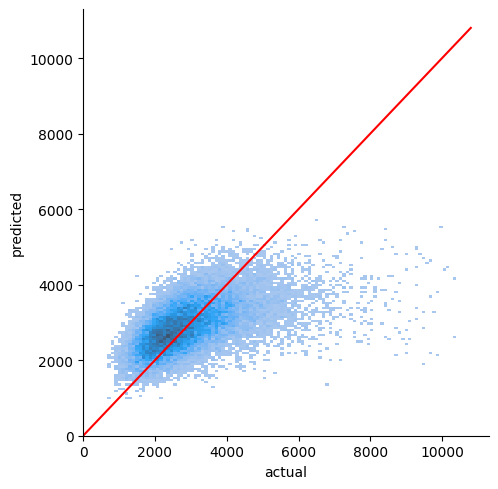

In [24]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

# Inference

In [27]:
model.summary()

Model summary:
       Log-lik            AIC            BIC
-721202.290000 1442460.580000 1442723.470000
Nb. observations: 88345
Nb. groups: 5194 (store_id)
-----------------------------------------------------
Covariance parameters (random effects):
                  Param.   Std. dev.
Error_term 676392.683400 3300.003100
store_id   131939.233000 4249.431700
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                                   Param.  Std. dev.  \
market_id                                        0.607200   0.075800   
store_primary_category                           0.158500   0.037600   
order_protocol                                   0.084800   0.072700   
total_items                                     15.461500   2.505200   
subtotal                                         0.086100   0.003300   
min_item_price                                  -0.019100   0.007600   
max_item_price                  

In [28]:
# Get model parameters for SHAP
coefs = model.get_coef().iloc[:-1, :-1].values.flatten()
intercept = model.get_coef().iloc[:-1, -1].values

In [29]:
# Get data parameters for SHAP
X_train_no_intercept = X_train.drop("intercept", axis = 1)
means = X_train_no_intercept.mean().values
covs = X_train_no_intercept.cov().values

In [31]:
explainer = shap.LinearExplainer(
    (coefs, intercept), 
    (means, covs)
)
explainer.expected_value = explainer.expected_value[0] # To fix slicing issue with some SHAP plots
shap_values = explainer(X_train_no_intercept)

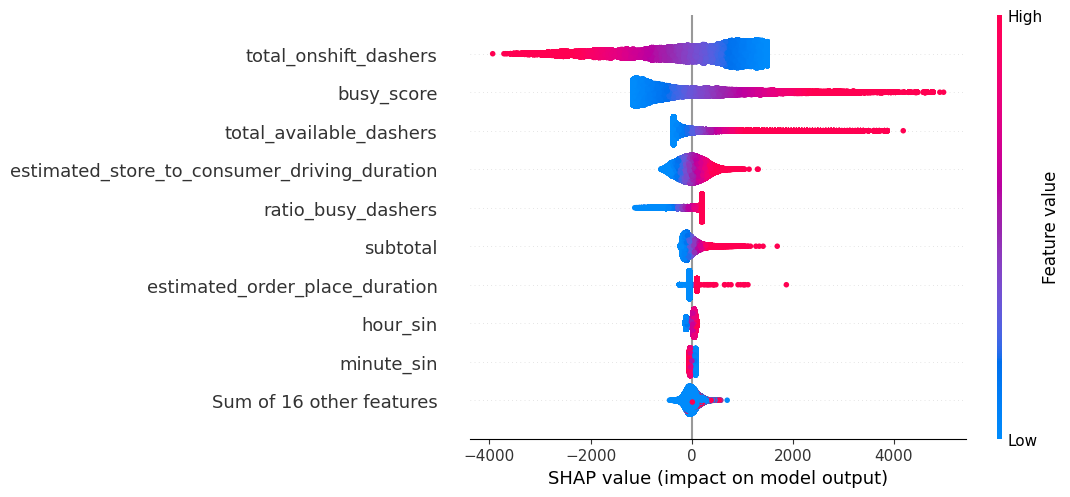

In [32]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

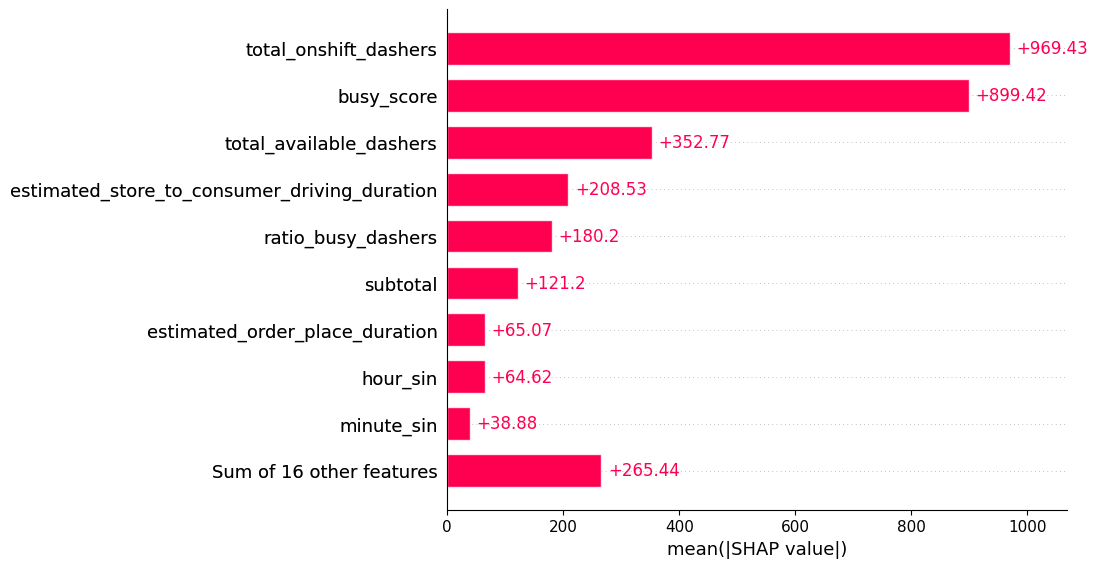

In [33]:
shap.plots.bar(shap_values)

# Findings

- Performance considerably better than fixed effects LM. Close to fixed effects XGB and LGBM. Better than GPBoost1 and GPBoost2, and a random effect model only.
- Dropping "num_distinct_items", "total_outstanding_orders" and "total_busy_dashers" is enough to get rid of rank deficiency, yields the best performance, and the smallest covariance parameter for store_id.
- Some fixed parameters change considerably compared to fixed effects LM. Most notably:
    - Store_primary_category flips its sign. It now has a positive effect on predictions rather than negative, which is what we'd expect as the feature is target encoded.
    - market_id has a much larger effect.